# Lab3 - AI - Convolutional Neural networks for image recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

**Setting up the environment**


In [ ]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# what is your GPU ?
!nvidia-smi

Mon Dec  4 11:13:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  CNNs for Cifar10 - training from scratch

Now let's build CNN models to work on the CIFAR10 dataset.

Try to reach the best performance on validation by designing other CNNs.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  50000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 3, 32, 32])
torch.Size([64])


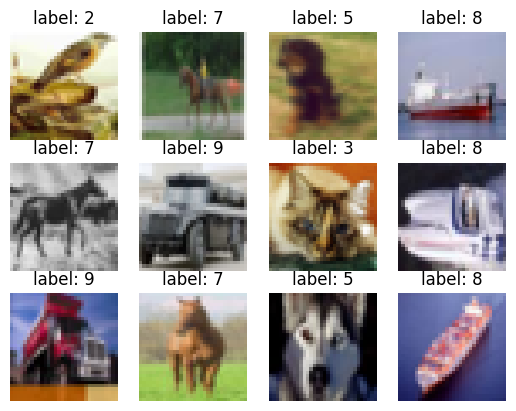

In [ ]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') # (img/2+0.5) is just to unnormalize the image
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [ ]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,        # different from Mnist car ce sont les images couleur
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # different from Mnist since the size of image is 32*32*3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN_cifar()
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

579402


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/20   Training loss: 2.2470   Validation loss: 2.1211   Train accuracy: 0.1784   Validation accuracy: 0.2615  
Epoch: 1/20   Training loss: 1.9975   Validation loss: 1.8912   Train accuracy: 0.2978   Validation accuracy: 0.3401  
Epoch: 2/20   Training loss: 1.8237   Validation loss: 1.7668   Train accuracy: 0.3567   Validation accuracy: 0.3697  
Epoch: 3/20   Training loss: 1.6985   Validation loss: 1.6501   Train accuracy: 0.3984   Validation accuracy: 0.4131  
Epoch: 4/20   Training loss: 1.5911   Validation loss: 1.5548   Train accuracy: 0.4336   Validation accuracy: 0.4476  
Epoch: 5/20   Training loss: 1.5108   Validation loss: 1.4768   Train accuracy: 0.4627   Validation accuracy: 0.4666  
Epoch: 6/20   Training loss: 1.4535   Validation loss: 1.4266   Train accuracy: 0.4828   Validation accuracy: 0.4929  
Epoch: 7/20   Training loss: 1.4089   Validation loss: 1.3919   Train accuracy: 0.4984   Validation accuracy: 0.5028  
Epoch: 8/20   Training loss: 1.3671   Validation

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

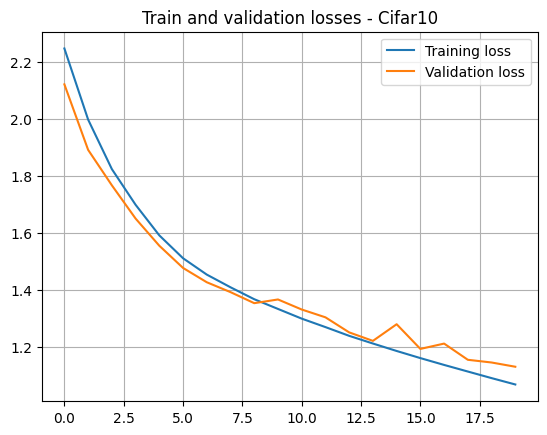

In [ ]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

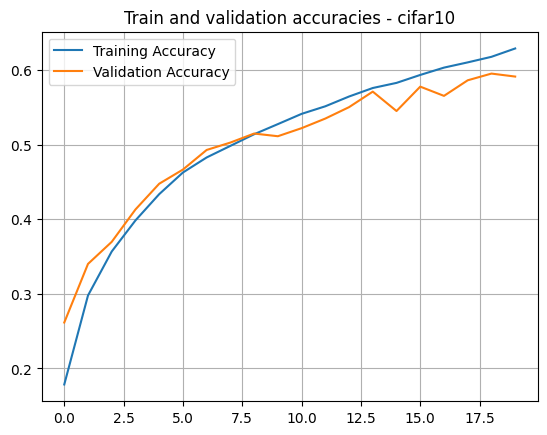

In [ ]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

## Transfer learning with pre-trained networks

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


**Transfer learning with Resnet18 - feature extraction technique**

In [ ]:
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model = model_conv
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

5130


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0/20   Training loss: 1.3277   Validation loss: 0.9372   Train accuracy: 0.6141   Validation accuracy: 0.7318  
Epoch: 1/20   Training loss: 0.8592   Validation loss: 0.7843   Train accuracy: 0.7425   Validation accuracy: 0.7572  
Epoch: 2/20   Training loss: 0.7583   Validation loss: 0.7237   Train accuracy: 0.7613   Validation accuracy: 0.7653  
Epoch: 3/20   Training loss: 0.7093   Validation loss: 0.6822   Train accuracy: 0.7712   Validation accuracy: 0.7760  
Epoch: 4/20   Training loss: 0.6816   Validation loss: 0.6590   Train accuracy: 0.7765   Validation accuracy: 0.7820  
Epoch: 5/20   Training loss: 0.6606   Validation loss: 0.6516   Train accuracy: 0.7814   Validation accuracy: 0.7824  
Epoch: 6/20   Training loss: 0.6448   Validation loss: 0.6335   Train accuracy: 0.7849   Validation accuracy: 0.7884  
Epoch: 7/20   Training loss: 0.6330   Validation loss: 0.6227   Train accuracy: 0.7895   Validation accuracy: 0.7922  
Epoch: 8/20   Training loss: 0.6222   Validation

**Transfer learning with Resnet18 - Finetuning technique**

In [ ]:
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')

#for param in model_ft.parameters():  # here to modify to finetune only some last layers !!!!!
#    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# for layer in self.layers[0:-1]:
#         for param in self.model.fc_layers[layer].parameters():
#             param.requires_grad = False

In [ ]:
# # Freeze all layers except the last 3
# for name, param in resnet.named_parameters():
#     if "layer4" in name or "fc" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False